In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from collections import Counter
from itertools import chain 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import logging

from keras.models import Sequential
from keras.layers import SpatialDropout1D, LSTM, Dense, Embedding
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

#Read Dataset

In [4]:
df = pd.read_csv('dataset_racism.csv', sep=',')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df

,tweets,label
0,Trus nih buat yg nanya kenapa gak dibangun di ...,Non_R
1,PLAY & Let The Fun Begin 😱\nLike + RT + Click ...,Non_R
2,Papua adalah bagian dari NKRI\n#DukungOtsusPap...,Non_R
3,Akar konflik harus dibicarakan.\nDan dicari ti...,Non_R
4,"""Saya minta kita semua jadi orang Papua. Artin...",Non_R
...,...,...
681,"Hitam itu cantik, putih itu cantik, gendut itu...",Non_R
682,Koleksinyaaaaa kribo smua ik....kaya yg py obs...,Non_R
683,ALAN KRIBO - Perjalanan Mencari Kayu Hitam Kal...,Non_R
684,ALAN KRIBO - Perjalanan Mencari Kayu Hitam Kal...,Non_R


#Data Preprocessing

In [5]:
def preprocessing(str):
    #lowercase string
    str = str.lower()
    #remove rt, mention and link
    str = re.sub('rt |@[a-z]*|http([a-z]|[0-9]|/|:|.)*|pic.twitter.com/([a-z]|[0-9])*', '', str)
    #remove punctuation and emoticon
    str = re.sub('[^a-z0-9]+', ' ', str)
    #remove extra white spaces
    str = ' '.join(str.split())
    #tokenization
    # str = str.split()
    # if str == []:
        # return float('NaN')
    return str

In [6]:
df['preprocessed'] = df.tweets.apply(preprocessing)
df.preprocessed = df.preprocessed.apply(str)

In [7]:
df.head()

,tweets,label,preprocessed
0,Trus nih buat yg nanya kenapa gak dibangun di ...,Non_R,trus nih buat yg nanya kenapa gak dibangun di ...
1,PLAY & Let The Fun Begin 😱\nLike + RT + Click ...,Non_R,play let the fun begin like click did you see it
2,Papua adalah bagian dari NKRI\n#DukungOtsusPap...,Non_R,papua adalah bagian dari nkri dukungotsuspapua...
3,Akar konflik harus dibicarakan.\nDan dicari ti...,Non_R,akar konflik harus dibicarakan dan dicari titi...
4,"""Saya minta kita semua jadi orang Papua. Artin...",Non_R,saya minta kita semua jadi orang papua artinya...


#Data Analysis

Class Non-Racist : 511
Class Racist     : 175


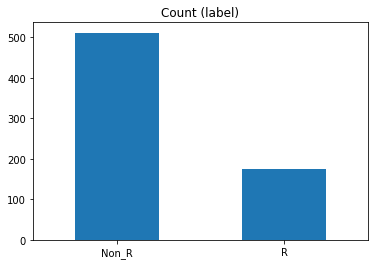

In [8]:
df_R = df[df.label == 'R']
df_NonR = df[df.label == 'Non_R']

label_count = df['label'].value_counts()
print('Class Non-Racist :', label_count[0])
print('Class Racist     :', label_count[1])

label_count.plot(kind='bar', title='Count (label)',rot=0)

In [9]:
df['preprocessed'][df.label == 'R'].iloc[0]

'dan ketika vk berhasil menyerahkan papua pada majikan cina nya ketika imigran cina mengalir deras penjarahan sejati sebagaimana yg cuma org cina bisa lakukan terjadi ketika genosida beneran oleh cina pada oap terjadi saat itu oap akan menyesal mereka pernah mengenal vk'

In [10]:
def generateWordCloud(df_tweets):
  # split texts by whitespace and turn them to array
  tweets = df_tweets.str.split(" ").tolist()

  # flatten the 2d array to 1d array
  tweets = list(chain.from_iterable(tweets))

  # count most common 20 racist words
  common_words = dict(Counter(tweets).most_common(20))
  # print(common_words)

  # set wordcloud values
  wordcloud = WordCloud(background_color="white",width=1500,height=1500,relative_scaling=0.5,min_font_size=10).generate_from_frequencies(common_words)

  return wordcloud

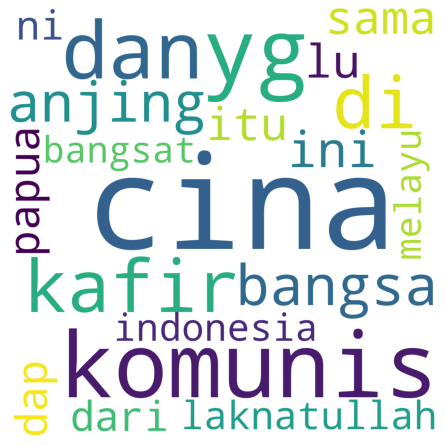

In [11]:
# generate wordcloud racist
wc_R = generateWordCloud(df[df['label'] == 'R']['preprocessed'])

# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wc_R) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

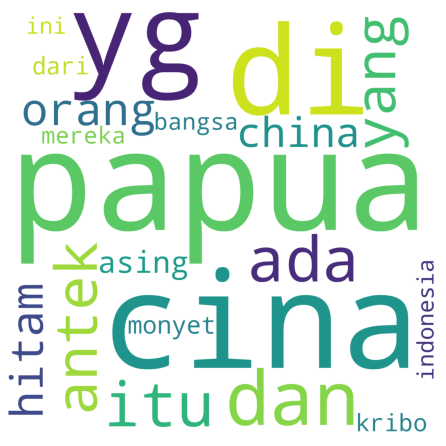

In [12]:
# generate wordcloud non-racist
wc_NonR = generateWordCloud(df[df['label'] == 'Non_R']['preprocessed'])

# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wc_NonR) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

# LSTM

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['preprocessed'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4565 unique tokens.


In [41]:
# get key from word index dictionary
def get_key(val): 
    for key, value in word_index.items(): 
         if val == value: 
             return key 

    return "key doesn't exist"
  
get_key(922)

'mie'

In [42]:
X = tokenizer.texts_to_sequences(df['preprocessed'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (686, 250)
Shape of label tensor: (686, 2)


In [43]:
# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(617, 250) (617, 2)
(69, 250) (69, 2)


In [44]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 8
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/8
9/9 [==============================] - 6s 688ms/step - loss: 0.6589 - accuracy: 0.6973 - val_loss: 0.5811 - val_accuracy: 0.7419
Epoch 2/8
9/9 [==============================] - 6s 646ms/step - loss: 0.5626 - accuracy: 0.7387 - val_loss: 0.5602 - val_accuracy: 0.7419
Epoch 3/8
9/9 [==============================] - 6s 639ms/step - loss: 0.5071 - accuracy: 0.7423 - val_loss: 0.5212 - val_accuracy: 0.7419
Epoch 4/8
9/9 [==============================] - 6s 660ms/step - loss: 0.3989 - accuracy: 0.7676 - val_loss: 0.4335 - val_accuracy: 0.7581
Epoch 5/8
9/9 [==============================] - 6s 650ms/step - loss: 0.2717 - accuracy: 0.9099 - val_loss: 0.4672 - val_accuracy: 0.7742
Epoch 6/8
9/9 [==============================] - 6s 649ms/step - loss: 0.2223 - accuracy: 0.9495 - val_loss: 0.3998 - val_accuracy: 0.8226
Epoch 7/8
9/9 [==============================] - 6s 647ms/step - loss: 0.1238 - accuracy: 0.9694 - val_loss: 0.3920 - val_accuracy: 0.8065
Epoch 8/8
9/9 [============

In [45]:
accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3/3 [==============================] - 0s 34ms/step - loss: 0.4532 - accuracy: 0.7971
Test set
  Loss: 0.453
  Accuracy: 0.797


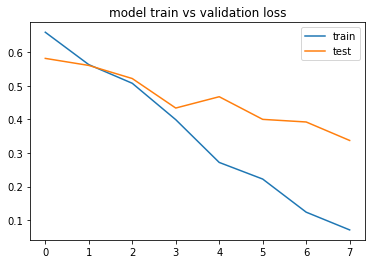

In [46]:
plt.title('model train vs validation loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

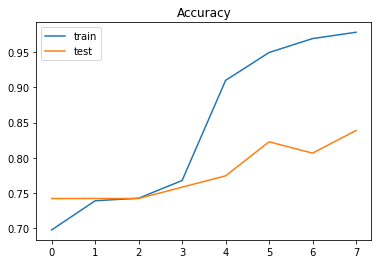

In [47]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();